In [100]:
import pandas as pd
import numpy as np
from pathlib import Path

In [101]:
code_dir=Path.cwd()
project_dir=code_dir.parent
tract_dir = project_dir.parent/"tractseg/tractseg_output/TOM_trackings"
input_dir=project_dir/"input"
output_dir=project_dir/"output/tract_based_statistics"
tmp_dir=project_dir/"tmp"

output_dir.mkdir(exist_ok=True)

In [110]:
statistics_df = pd.read_csv(input_dir/"toi_statistics.csv", index_col=0)

In [111]:
fa_columns = [col for col in roi_df.columns if "_FA" in col and "_FAt" not in col]
fat_columns = [col for col in roi_df.columns if "_FAt" in col]
md_columns = [col for col in roi_df.columns if "_MD" in col and "_MDt" not in col]
fw_columns = [col for col in roi_df.columns if "_FW" in col]
fd_columns = [col for col in roi_df.columns if "_fd" in col and "_fdc" not in col]
fc_columns = [col for col in roi_df.columns if "_logfc" in col]
fdc_columns = [col for col in roi_df.columns if "_fdc" in col]
complexity_columns = [col for col in roi_df.columns if "_complexity" in col]

In [112]:
columns = [fa_columns,
fat_columns,
md_columns,
fw_columns,
fd_columns,
fc_columns,
fdc_columns,
complexity_columns]

In [113]:
metrics = ["fa",
"fat",
"md",
"fw",
"fd",
"fc",
"fdc",
"complexity"]

metrics_styled = ["FA",
"FAt",
"MD",
"FW",
"FD",
"Log. FC",
"FDC",
"Complexity"]

In [115]:
def get_ancova_results(metric_columns):

    from sklearn.model_selection import train_test_split 
    from pingouin import ancova

    p_dict = dict()
    eff_dict = dict()

    for col in metric_columns:
         
        ancova_df = ancova(data=statistics_df, dv=col, covar=["age", "sex", "years_of_education"], between="cohort")
        pval, cohen_f = float(ancova_df[ancova_df["Source"]=="cohort"]["p-unc"]), float(ancova_df[ancova_df["Source"]=="cohort"]["F"])
            
        p_dict[col] = pval
        eff_dict[col] = cohen_f
    
    return p_dict, eff_dict


In [116]:
p_dict = dict()
eff_dict = dict()

for metric,metric_columns in zip(metrics,columns):
    p_dict_metric, eff_dict_metric = get_ancova_results(metric_columns)
    p_dict[metric] = p_dict_metric.values()
    eff_dict[metric] = p_dict_metric.values()


In [117]:
tract_names = [("_").join(col.split("_")[1:-2]) for col in fa_columns]

In [118]:
p_df = pd.DataFrame(p_dict, index=tract_names)
eff_df = pd.DataFrame(eff_dict, index=tract_names)

In [119]:
p_df_signif = p_df * len(p_df.index) < 0.05

In [121]:
import nibabel as nib
import numpy as np
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import load_tractogram, save_tractogram
from dipy.io.utils import (create_nifti_header, get_reference_info,
                           is_header_compatible)

from dipy.tracking.streamline import select_random_set_of_streamlines
from dipy.tracking.utils import density_map

In [122]:
tract_paths = list(tract_dir.glob("*"))
reference_anatomy = nib.load(tract_dir.parent.parent/"wmfod_template_peaks.nii")

def load_tract(tract_path):
    tract = load_tractogram(tract_path, reference_anatomy)
    affine, dimensions, voxel_sizes, voxel_order = get_reference_info(reference_anatomy)
    tract.to_vox()
    tract_streamlines_vox = select_random_set_of_streamlines(tract.streamlines,
                                                       1000)
    tract_density = density_map(tract_streamlines_vox, np.eye(4), dimensions)

    return tract_streamlines_vox, tract_density

In [23]:
from dipy.viz import window, actor
import fury

for metric in metrics:

    renderer = window.Scene()

    hue = (1, 0.6)
    saturation = (0.0, 1.0)

    for idx,tract in enumerate(tract_paths):
        tract_name = tract.name.split(".")[0]
        if tract_name == "CC": continue
        tract_streamlines_vox, tract_density = load_tract(tract)
        if p_df_signif.loc[tract_name,metric] == True:
            stream_actor = actor.line(tract_streamlines_vox, linewidth=1, opacity=0.9, depth_cue=True) #colors_metric[idx], 
        else:
            stream_actor = actor.line(tract_streamlines_vox, (0.5,0.5,0.5), linewidth=1, opacity=0.05, depth_cue=True) #colors_metric[idx], 
        renderer.add(stream_actor)

    orientation="sagittal_right"
    renderer.set_camera(position=(-177.97, 118.29, 121.11),
                        focal_point=(111.75, 64.77, 59.47),
                        view_up=(0.18, 0.00, 0.98))
    #window.show(renderer, size=(600, 600), reset_camera=False)
    window.record(renderer, out_path=output_dir/f'{metric}_{orientation}_tractogram.png', size=(600, 600), magnification=7)

    orientation="sagittal_left"
    renderer.set_camera(position=(317.00, 27.70, 72.55),
                        focal_point=(111.77, 64.75, 71.23),
                        view_up=(-0.01, -0.11, 0.99))
    #window.show(renderer, size=(600, 600), reset_camera=False)
    window.record(renderer, out_path=output_dir/f'{metric}_{orientation}_tractogram.png', size=(600, 600), magnification=7)

    orientation="coronal"
    renderer.set_camera(position=(76.62, -133.61, 51.68),
                        focal_point=(71.29, 70.95, 71.55),
                        view_up=(0.03, -0.10, 1.00))
    #window.show(renderer, size=(600, 600), reset_camera=False)
    window.record(renderer, out_path=output_dir/f'{metric}_{orientation}_tractogram.png', size=(600, 600),magnification=7)

    orientation="superior"
    renderer.set_camera(position=(66.50, 45.19, 324.60),
                        focal_point=(71.24, 72.75, 69.97),
                        view_up=(0.02, -0.99, -0.11))
    #window.show(renderer, size=(600, 600), reset_camera=False)
    window.record(renderer, out_path=output_dir/f'{metric}_{orientation}_tractogram.png', size=(600, 600), magnification=7)

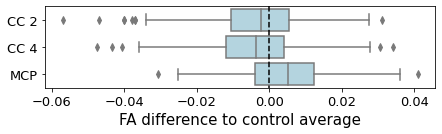

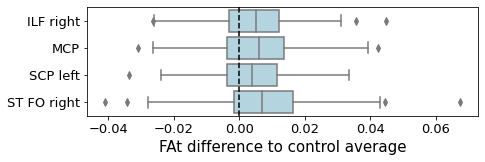

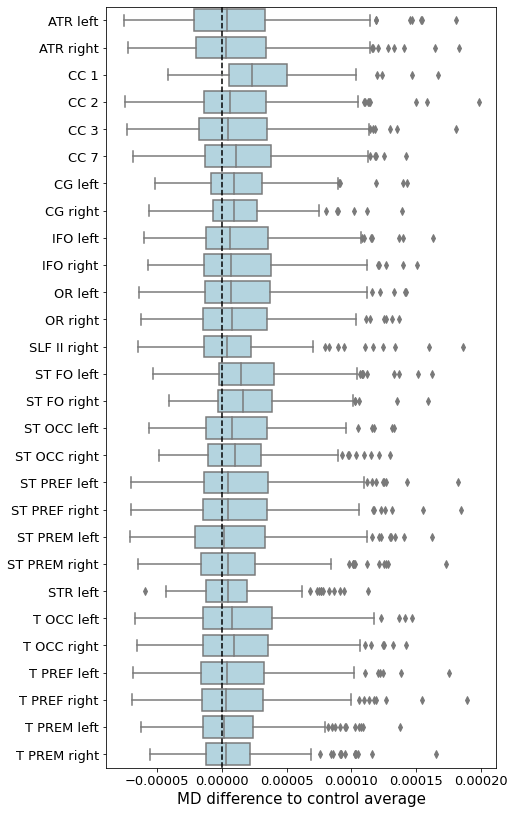

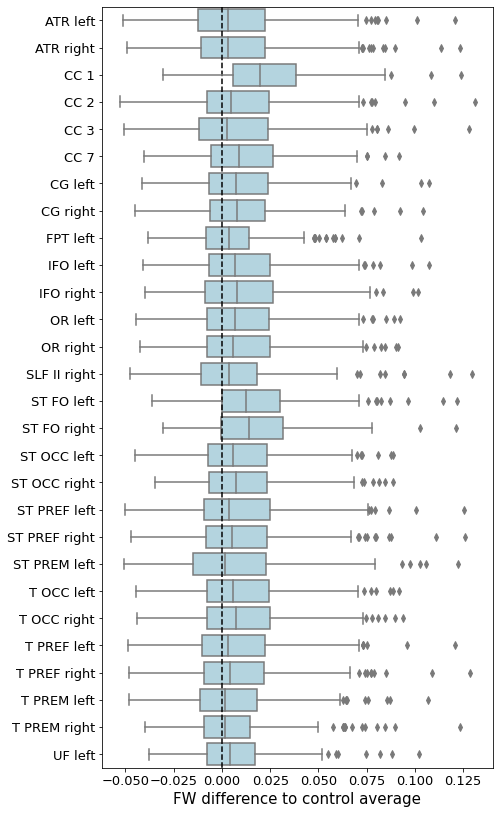

In [26]:

import seaborn as sns
import matplotlib.pyplot as plt

for idx, metric in enumerate(metrics):
    metric_styled = metrics_styled[idx]

    sns.set_palette("Blues")

    columns_signif_styled = p_df_signif[p_df_signif[metric] == True].index
    columns_signif_styled_nounderscore = [col.replace("_", " ") for col in columns_signif_styled]
    columns_signif = [f"fba_{col}_mean_{metric_styled}" for col in columns_signif_styled]

    if columns_signif_styled.shape[0] == 0: continue

    metric_df_controls = statistics_df[statistics_df["cohort"] == 0][columns_signif]
    metric_df_patients = statistics_df[statistics_df["cohort"] == 1][columns_signif]
    metric_df_controls_mean = metric_df_controls.mean(axis=0)
    metric_df_patients_diff = metric_df_patients - metric_df_controls_mean

    metric_df_patients_diff_molten = pd.melt(metric_df_patients_diff)
    metric_df_patients_diff_molten.rename(columns={"value": f"{metric_styled} difference to control average"}, inplace=True)

    f, ax = plt.subplots(figsize=(7, len(columns_signif_styled) * 0.5))
    sns.boxplot(data=metric_df_patients_diff_molten, y="variable", x=f"{metric_styled} difference to control average", color="lightblue")

    ax.set_yticklabels(columns_signif_styled_nounderscore)
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    ax.set_ylabel("")
    plt.xlabel(f"{metric_styled} difference to control average",fontsize=15)
    ax.vlines(0, -0.5, len(columns_signif_styled) -0.5, colors="black", linestyles="dashed")

    plt.savefig(output_dir/f"{metric}_difference_boxplot.png", dpi=300, bbox_inches="tight")


In [35]:
helper_dict = {
    "FD": "fd",
    "Log. FC": "logfc",
    "FDC": "fdc",
    "Complexity": "complexity"
}

helper_dict_inv = {v: k for k, v in helper_dict.items()}

In [62]:
columns_signif_styled = p_df_signif[p_df_signif["fa"] == True].index

In [99]:
len(columns)

71

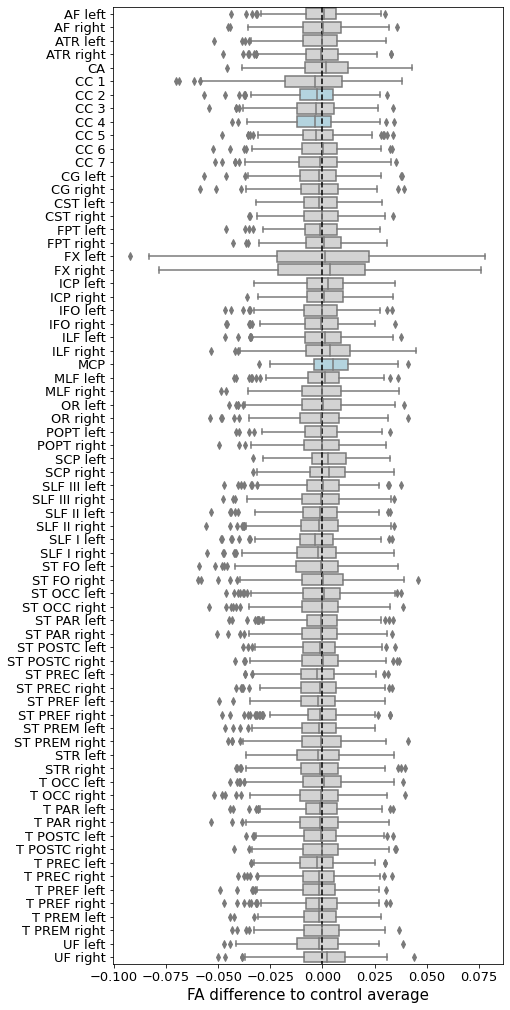

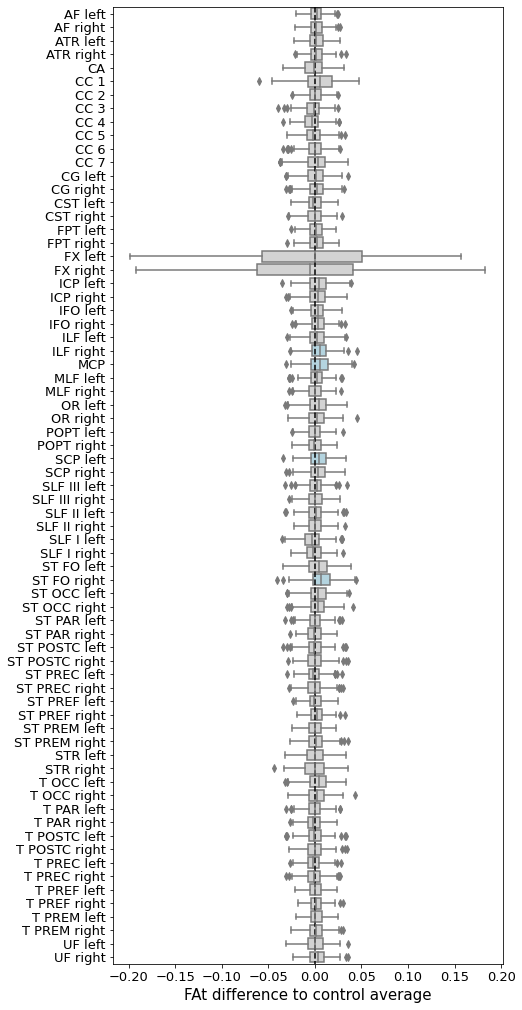

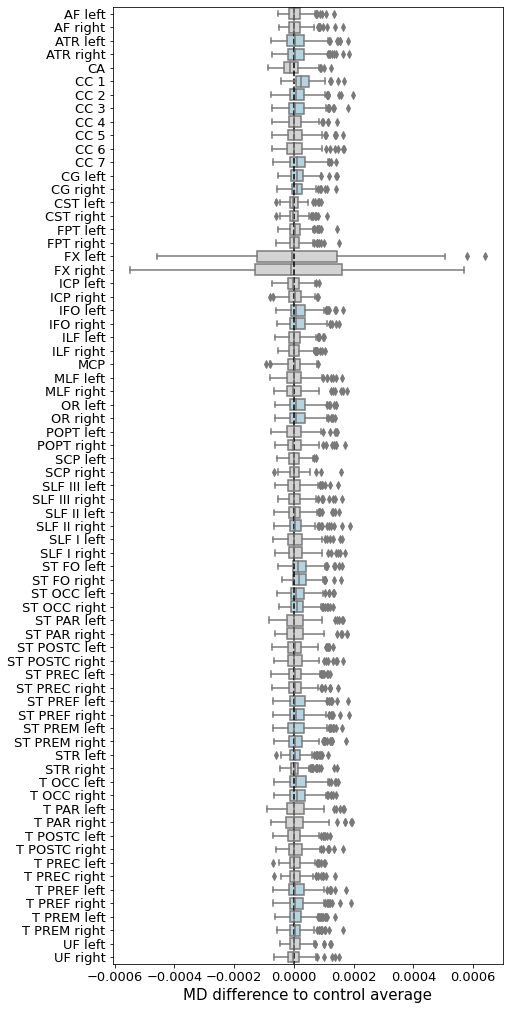

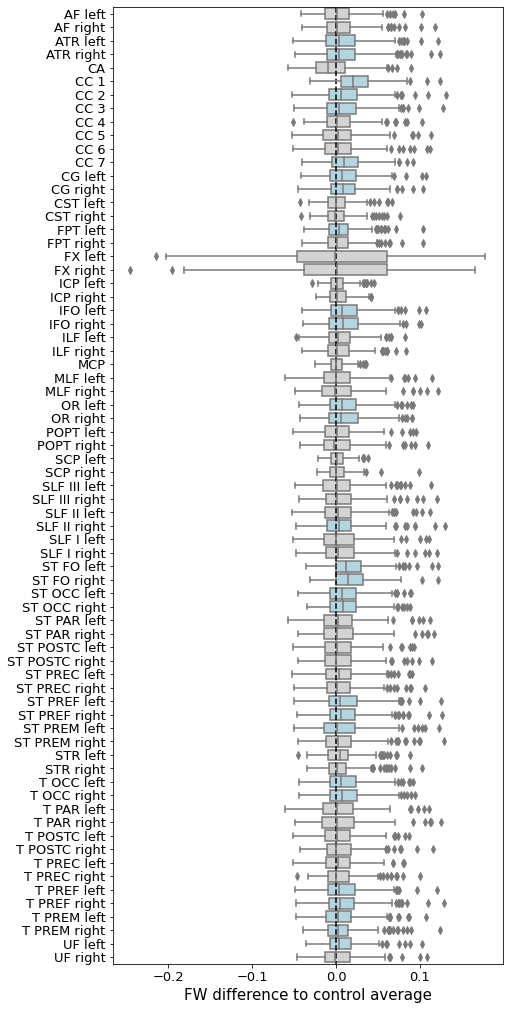

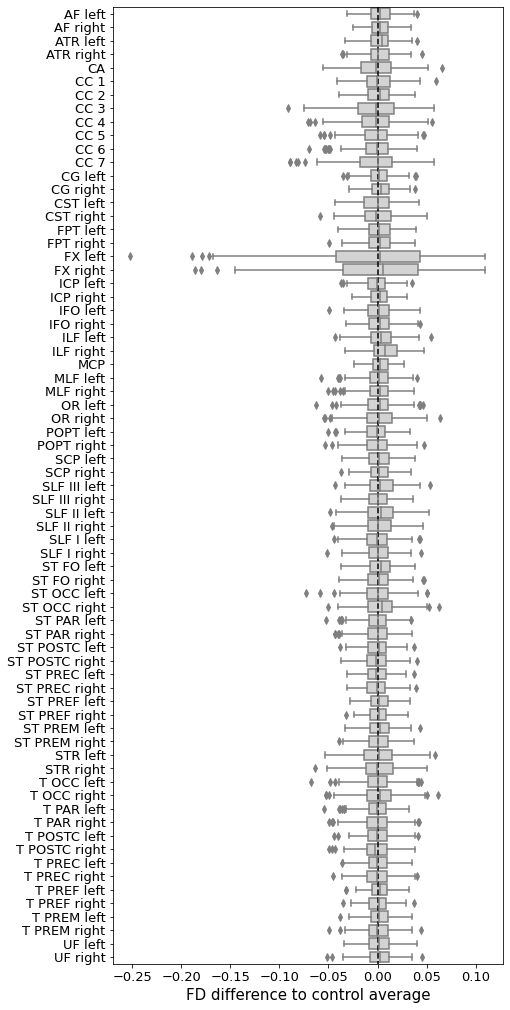

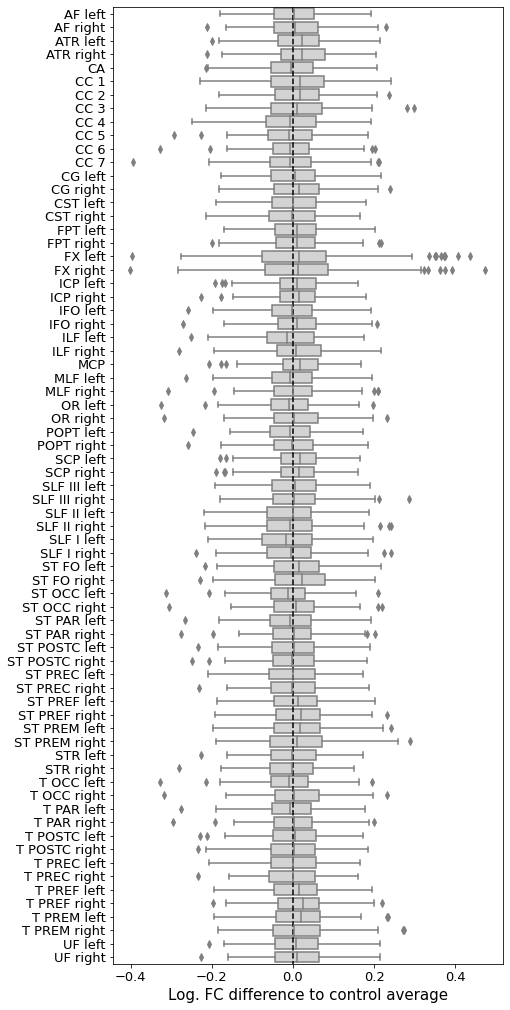

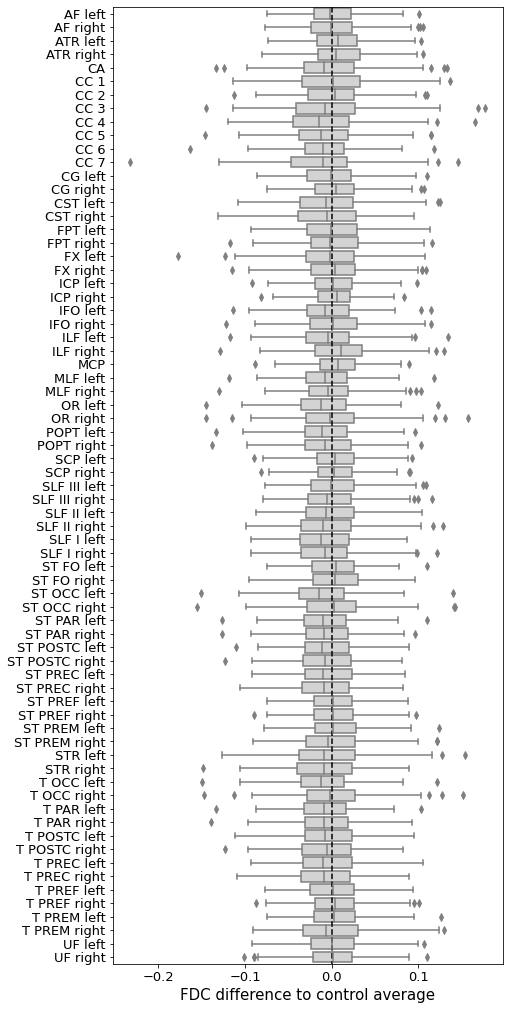

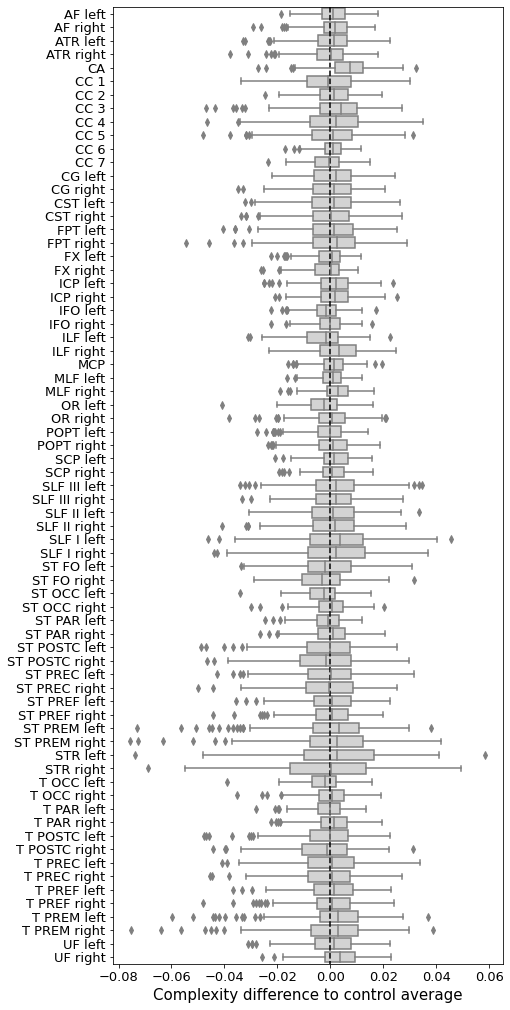

In [97]:

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

for idx, metric in enumerate(metrics):
    metric_styled = metrics_styled[idx]
    if metric_styled in helper_dict.keys(): metric_styled = helper_dict[metric_styled]
    sns.set_palette("Blues")

    columns_styled = p_df_signif.index
    columns_signif_styled = p_df_signif[p_df_signif[metric] == True].index
    columns_styled_nounderscore = [col.replace("_", " ") for col in columns_styled]
    columns = [f"fba_{col}_mean_{metric_styled}" for col in columns_styled]

    metric_df_controls = statistics_df[statistics_df["cohort"] == 0][columns]
    metric_df_patients = statistics_df[statistics_df["cohort"] == 1][columns]
    metric_df_controls_mean = metric_df_controls.mean(axis=0)
    metric_df_patients_diff = metric_df_patients - metric_df_controls_mean

    metric_df_patients_diff_molten = pd.melt(metric_df_patients_diff)
    metric_df_patients_diff_molten.rename(columns={"value": f"{metric_styled} difference to control average"}, inplace=True)

    color_dict = {k: "lightblue" if k in columns_signif_styled else "lightgrey" for k in columns_styled}

    f, ax = plt.subplots(figsize=(7, len(metrics) * 2.2))
    sns.boxplot(data=metric_df_patients_diff_molten, y="variable", x=f"{metric_styled} difference to control average", #color="lightblue")
                palette=color_dict.values())
    ax.set_yticklabels(columns_styled_nounderscore)
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    ax.set_ylabel("")
    if metric_styled in helper_dict_inv.keys(): metric_styled = helper_dict_inv[metric_styled]
    plt.xlabel(f"{metric_styled} difference to control average",fontsize=15)
    ax.vlines(0, -0.5, len(columns_styled) -0.5, colors="black", linestyles="dashed")

    plt.savefig(output_dir/f"{metric}_difference_boxplot_all.png", dpi=300, bbox_inches="tight")
